<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Project with Linear Regression

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
# pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

In [2]:
def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=50000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

In [3]:
df_main_refined = pd.read_csv('main_refined.csv')
df_main_refined.drop(columns = ['Unnamed: 0'], inplace = True)

In [4]:
df_main_refined

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,interaction_1
0,109,69.0552,13517,6,34,5,4,3,5,725.0,...,0,0,0,0,0,0,0,0,1,4.667934e+09
1,544,43.0000,11492,7,13,12,4,4,5,913.0,...,0,0,0,0,0,0,0,0,1,1.009925e+10
2,153,68.0000,7922,5,57,3,3,3,3,1057.0,...,0,0,0,0,0,0,0,0,1,1.651671e+09
3,318,73.0000,9802,5,4,3,3,4,4,384.0,...,0,0,0,0,0,0,0,0,1,1.447857e+09
4,255,82.0000,14235,6,110,17,3,2,3,676.0,...,0,0,0,0,0,0,0,0,1,1.101366e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,80.0000,8000,6,33,33,3,3,3,1084.0,...,0,0,0,0,0,0,0,0,1,2.041468e+09
2925,1234,90.0000,14670,6,42,9,4,3,5,1104.0,...,0,0,0,0,0,0,0,0,1,8.585287e+09
2926,1373,55.0000,8250,5,40,40,3,3,5,952.0,...,0,0,0,0,0,0,0,0,1,2.290833e+09
2927,1672,60.0000,9000,4,36,36,3,3,3,864.0,...,0,0,0,0,0,0,0,0,1,7.806150e+08


In [5]:
main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu', 'total_bsmt_sf_class', 'neighborhood_class', 'gr_liv_area_class',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]

**Set up variables**

In [6]:
df_main_refined.drop(index = [960,1885], inplace = True)

In [7]:
# split test data (Kaggle)
# cross check -->> OK
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

Indexer: 2049


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [8]:
# split train data (Kaggle)
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_train_final = df_main_refined[:indexer]
kaggle_train_final['sale_price'].tail(10)

Indexer: 2049


2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

**Scale and lasso**

In [9]:
#  scale and lasso 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 445590284.878725
MSE for test: 346261987.9717295
Underfited by: 99328296.90699548
RMSE: 18608.11618546406
Lasso alpha used: 786.4078625556068


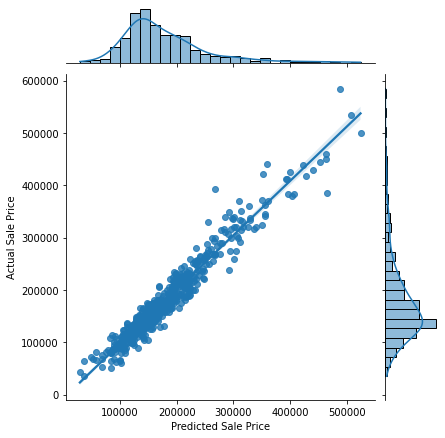

In [10]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

<AxesSubplot:>

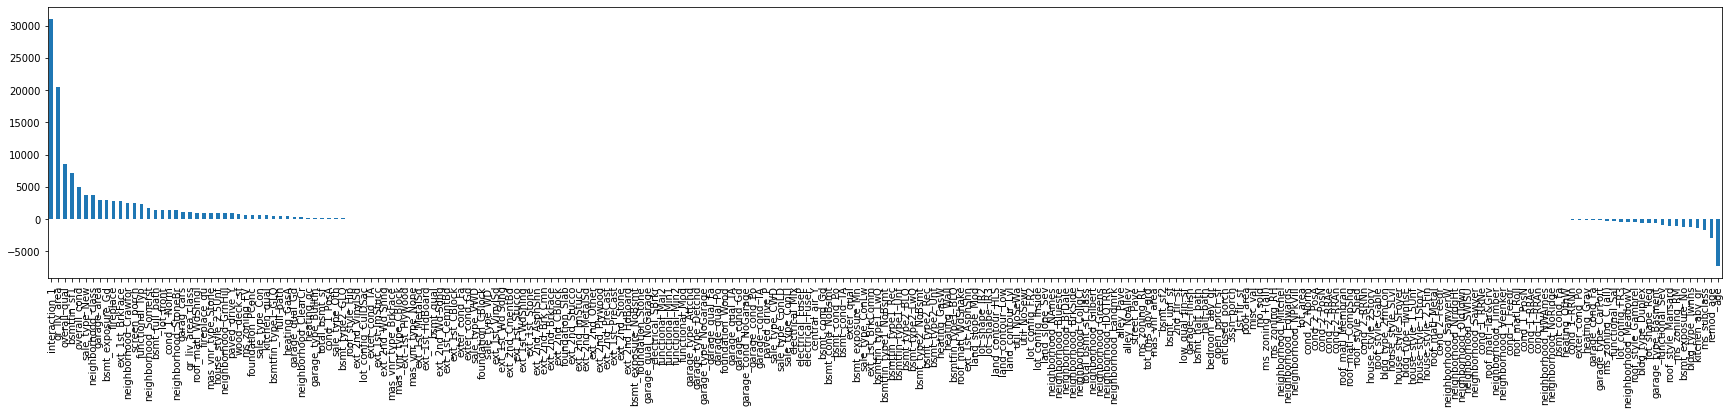

In [11]:
# hwo to plot the series 
plt.figure(figsize=(30,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

**Optimise model**

In [12]:
feature_set_model = SelectFromModel(lasso_best)
feature_set_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=786.4078625556068))

In [13]:
feature_set_model.get_support()

array([ True, False,  True,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False, False, False, False,
        True, False,  True, False, False,  True,  True,  True,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,

In [14]:
len(feature_set_model.get_support())

241

In [15]:
len(kaggle_train_final.columns)

243

In [16]:
#refined model from 534 columns to 215 columns 

refined = list(kaggle_train_final.columns.drop(['sale_price','id'])[feature_set_model.get_support()])
print(f'Reduced from {len(kaggle_train_final.columns)} to {len(refined)}')


Reduced from 243 to 70


In [17]:
# remove all pairwise features and zero-ed features by Lasso
for col in ['sale_price','id']:
        refined.append(col)

filter_list_of_pairwise = ['garag_cars', '2nd_flr_sf', 'tot_rms_abv_grd', 'bsmt_full_bath', 'half_bath', 'full_bath']

filter_list = [col for col in df_main_refined[refined].columns if col in filter_list_of_pairwise]

# rebuild df main
df_main_refined = df_main_refined[refined].drop(columns = filter_list, axis = 1)

In [18]:
indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head(5))

kaggle_train_final = df_main_refined[:indexer]
print(kaggle_train_final['sale_price'].tail(10))

Indexer: 2049
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sale_price, dtype: float64
2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64


In [19]:
#  scale and lasso with refined variables 
# taking only refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 415369296.1303572
MSE for test: 342347310.9613771
Underfited by: 73021985.16898012
RMSE: 18502.6298390628
Lasso alpha used: 116.54727355104309


Text(27.125, 0.5, 'Actual Sale Price')

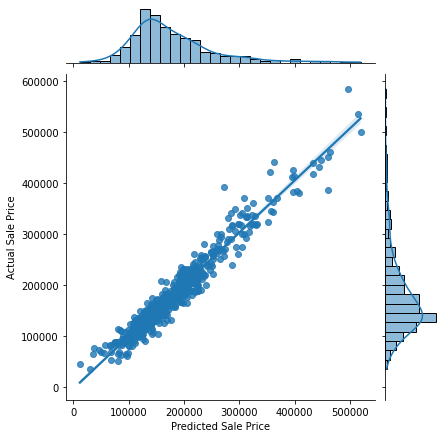

In [20]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')


**Make Trade-off of higher RMSE for lower amount of features**

In [21]:
# Creating filter df to tell us remaining columns needed for final model

# to create df for lasso coeff

lasso_coeff = pd.DataFrame(lasso_best.coef_)
lasso_coeff.reset_index(drop = True, inplace= True)
lasso_coeff.rename(columns = {0: 'lasso_coeff'}, inplace = True)

# to create df for features 
feat = pd.DataFrame(kaggle_train_final.columns.drop('sale_price'))
feat.reset_index(drop = True, inplace = True)
feat.rename(columns = {0: 'feature'}, inplace = True)


# combine df and filter off columns for 

filter_df = pd.concat([lasso_coeff,feat], axis = 1)

filter_df['feature_in_main'] = filter_df['feature'].map(lambda x: True if x in main_variables else False)
val = 1500
filter_df2 = filter_df[((filter_df['feature_in_main'] == False) &\
            ((filter_df['lasso_coeff'] >= val) | (filter_df['lasso_coeff'] <= -val)) |\
            (filter_df['feature_in_main'] == True))]

print((f'Remaining columns in final model: {len(filter_df2)}'))
filter_df2.sort_values(by = 'feature', ascending = True)

Remaining columns in final model: 34


,lasso_coeff,feature,feature_in_main
2,-7428.450033,age,True
35,-1710.337142,bldg_type_Twnhs,False
47,3060.248200,bsmt_exposure_Gd,False
48,-1774.314170,bsmt_exposure_No,False
12,8177.851611,bsmtfin_sf1,True
31,2081.514629,cond_1_Norm,False
41,3193.883869,ext_1st_BrkFace,False
16,2436.412258,fireplace,False
8,1253.657851,fireplace_qu,True
56,2872.650164,functional_Typ,False


In [22]:
# Extracting Refined columns 
# Noted that we can remove 'neighborhood_class', 'gr_liv_area_class','heating_qc' as they are poor scored against RMSE

remove = ['neighborhood_class', 'gr_liv_area_class']

filter_columns = [col for col in list(filter_df2['feature']) if col not in remove]
filter_columns

['lot_front',
 'overall_qual',
 'age',
 'remod_age',
 'heating_qc',
 'total_bsmt_sf',
 'gr_liv_area',
 'kitchen_qual',
 'fireplace_qu',
 'garage_area',
 'bsmtfin_sf1',
 'ms_subclass',
 'overall_cond',
 'kitchen_abv_gr',
 'fireplace',
 'screen_porch',
 'neighborhood_Crawfor',
 'neighborhood_GrnHill',
 'neighborhood_Somerst',
 'neighborhood_StoneBr',
 'cond_1_Norm',
 'bldg_type_Twnhs',
 'house_style_2.5Unf',
 'roof_style_Mansard',
 'roof_matl_WdShngl',
 'ext_1st_BrkFace',
 'mas_vnr_type_Stone',
 'bsmt_exposure_Gd',
 'bsmt_exposure_No',
 'functional_Typ',
 'sale_type_New',
 'interaction_1']

In [23]:
#  Scale and Lasso regression on refined columns 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 419449103.7932249
MSE for test: 374596556.344526
Underfited by: 44852547.44869888
RMSE: 19354.497057390203
Lasso alpha used: 69.24229677491185


Text(27.125, 0.5, 'Actual Sale Price')

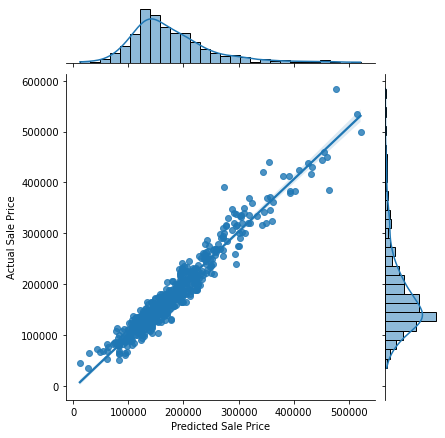

In [24]:
# noticed still have some outliers 

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg',
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')


Text(0.5, 1.0, 'Predictions vs Residults from Lasso regression')

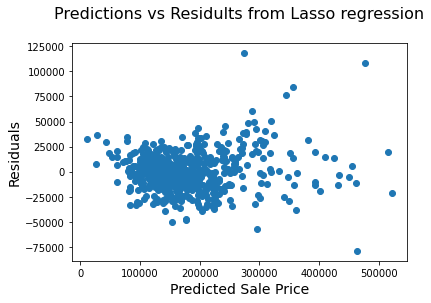

In [25]:
residuals = y_test - lasso_best.predict(X_test)
plt.scatter(lasso_best.predict(X_test), residuals)
plt.xlabel('Predicted Sale Price', fontdict={'fontsize': 14})
plt.ylabel('Residuals', fontdict={'fontsize': 14})
plt.title('Predictions vs Residults from Lasso regression',  fontdict={'fontsize': 16}, pad = 25)

**Comment**

- consistently seeing high outlier 

In [26]:
# find out number 286, 317 having anomaly
anomaly = [num for num,val in enumerate (residuals > 100000) if val == True]
anomaly

[286, 317]

In [27]:
#index with anomoly
anomoly = [indices_test[anol] for anol in anomaly]
anomoly

[1136, 1692]

In [28]:
# ID filter into main dataframe
id_filter = [int(df_main_refined.loc[df_main_refined.index == outlier, 'id'].values) for outlier in anomoly]
id_filter

[1641, 2451]

In [29]:
# Referencing new set of columns 

final_columns = kaggle_train_final[filter_df2['feature']].drop(columns = ['neighborhood_class', 'gr_liv_area_class','heating_qc']).columns 

In [30]:
# creating df to compare outliers between holdup and train score

reference_df = pd.concat([df_main_refined[['id','sale_price']],df_main_refined[final_columns]], axis = 1)
reference_df

,id,sale_price,lot_front,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,fireplace_qu,...,house_style_2.5Unf,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,mas_vnr_type_Stone,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1
0,109,130500.0,69.0552,6,34,5,725.0,1479,4,0,...,0,0,0,0,0,0,1,1,0,4.667934e+09
1,544,220000.0,43.0000,7,13,12,913.0,2122,4,3,...,0,0,0,0,0,0,1,1,0,1.009925e+10
2,153,109000.0,68.0000,5,57,3,1057.0,1057,4,0,...,0,0,0,0,0,0,1,1,0,1.651671e+09
3,318,174000.0,73.0000,5,4,3,384.0,1444,3,0,...,0,0,0,0,0,0,1,1,0,1.447857e+09
4,255,138500.0,82.0000,6,110,17,676.0,1445,3,0,...,0,0,0,0,0,0,1,1,0,1.101366e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,NaN,80.0000,6,33,33,1084.0,1877,3,3,...,0,0,0,0,0,0,1,1,0,2.041468e+09
2925,1234,NaN,90.0000,6,42,9,1104.0,1988,4,4,...,0,0,0,0,0,0,1,1,0,8.585287e+09
2926,1373,NaN,55.0000,5,40,40,952.0,1211,3,3,...,0,0,0,0,0,0,1,1,0,2.290833e+09
2927,1672,NaN,60.0000,4,36,36,864.0,864,3,0,...,0,0,0,0,0,0,1,1,0,7.806150e+08


In [31]:
# Declare indexer to split between Train and Test sets

indexer = reference_df.shape[0] - len(reference_df[pd.isnull(reference_df['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2049


In [32]:
#do cross test split with same random state to keep it consistent

X = reference_df[:indexer].drop(columns = 'sale_price')
y = reference_df[:indexer]['sale_price']

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state = 123
)

In [33]:
# creating holdup reference df
holdup = pd.DataFrame(X_test)
holdup.columns = reference_df.columns.drop('sale_price')
holdup['sale_price'] = y_test
holdup

,id,lot_front,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,fireplace_qu,garage_area,...,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,mas_vnr_type_Stone,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1,sale_price
564,1039,34.0000,6,10,9,1405.0,1337,4,0,511.0,...,0,0,0,0,0,1,1,0,6.131035e+09,181000.0
785,1976,50.0000,6,80,57,845.0,1296,3,0,576.0,...,0,0,0,0,0,1,1,0,1.159316e+09,127500.0
553,141,69.0552,5,51,51,1143.0,1143,3,0,308.0,...,0,0,0,0,0,1,1,0,1.404178e+09,136000.0
103,728,72.0000,3,109,59,245.0,797,3,0,0.0,...,1,0,0,0,0,1,1,0,1.958553e+08,44000.0
1882,1755,69.0552,7,5,5,854.0,1995,4,4,435.0,...,0,0,0,0,0,1,1,0,8.034540e+09,219500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,1821,70.0000,5,45,45,1057.0,1057,3,0,576.0,...,0,0,0,0,0,1,1,0,1.198863e+09,132000.0
1477,1640,61.0000,9,1,1,1612.0,1612,5,4,556.0,...,0,0,0,0,1,0,1,0,2.610676e+10,319900.0
996,2672,65.0000,6,67,56,972.0,1577,2,4,312.0,...,0,0,0,0,0,1,1,0,1.337643e+09,140200.0
1909,60,108.0000,9,11,11,1393.0,2599,4,3,779.0,...,0,0,0,0,0,1,1,0,2.511713e+10,333168.0


In [34]:
# creating train set reference df
train_set = pd.DataFrame(X_train)
train_set.columns = reference_df.columns.drop('sale_price')
train_set['sale_price'] = y_train
train_set

,id,lot_front,overall_qual,age,remod_age,total_bsmt_sf,gr_liv_area,kitchen_qual,fireplace_qu,garage_area,...,roof_style_Mansard,roof_matl_WdShngl,ext_1st_BrkFace,mas_vnr_type_Stone,bsmt_exposure_Gd,bsmt_exposure_No,functional_Typ,sale_type_New,interaction_1,sale_price
807,944,60.0000,4,84,59,572.0,572,3,0,200.0,...,0,0,0,0,0,1,1,0,2.984337e+08,75000.0
1317,2596,60.0000,3,76,5,713.0,713,4,0,371.0,...,0,0,0,0,0,1,1,0,1.048947e+09,99800.0
655,1037,63.0000,5,37,37,864.0,864,3,0,576.0,...,0,0,0,0,0,1,1,0,1.192409e+09,123000.0
1810,547,70.0000,6,17,17,816.0,1730,4,0,528.0,...,0,0,0,0,0,1,1,0,5.778589e+09,171500.0
1297,33,53.0000,6,33,33,1069.0,1069,3,2,440.0,...,0,0,0,0,0,1,1,0,1.440103e+09,127500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1363,69.0552,5,93,30,880.0,1308,3,0,400.0,...,0,0,0,0,0,1,1,0,1.745903e+09,120000.0
1767,1907,80.0000,5,52,52,1078.0,1150,3,0,288.0,...,0,0,0,0,0,1,1,0,2.497161e+09,144000.0
1123,14,85.0000,7,20,20,1300.0,1341,4,1,506.0,...,0,0,0,0,1,0,1,0,6.555235e+09,171500.0
2014,454,34.0000,6,4,4,1306.0,1306,4,4,624.0,...,0,0,0,1,0,0,1,0,6.485385e+09,184500.0


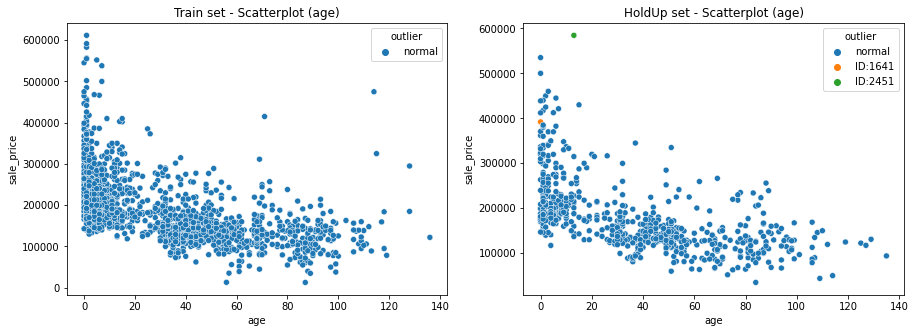

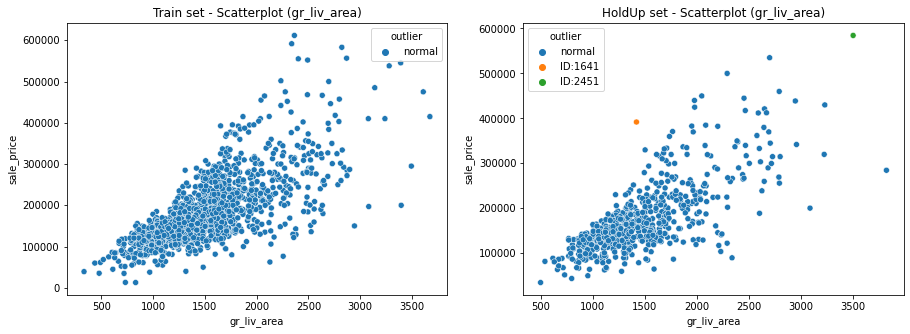

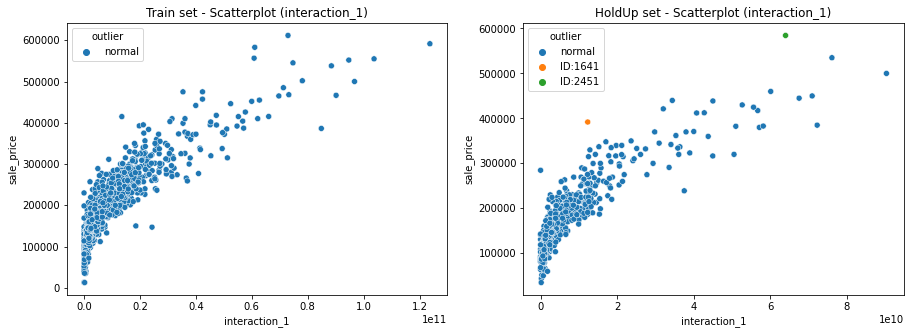

In [35]:
# Creating scatterplot against Sale price for Train and Holdup set

train_set['outlier'] = train_set['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'ID:2451' if x == id_filter[1] else 'normal')
holdup['outlier'] = holdup['id'].map(lambda x: 'ID:1641' if x == id_filter[0] else 'ID:2451' if x == id_filter[1] else 'normal')

for var in ['age','gr_liv_area','interaction_1' ]:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.scatterplot(ax = axes[0], x = var, y = 'sale_price', hue = 'outlier', data = train_set)
    axes[0].set_title(f'Train set - Scatterplot ({var})')
    
    sns.scatterplot(ax = axes[1], x = var, y = 'sale_price' , hue = 'outlier', data = holdup)
    axes[1].set_title(f'HoldUp set - Scatterplot ({var})')

**ID: 2451 Outlier**
- From year_remod_add in Holdup set, can see obvious flyer not consistent with Train set

**ID: 1641 Outlier** 
- From gr_liv_area in Holdup set, can see obvious flyer not consistent with Train set  

In [36]:
# **Remove outlier as very abnormal for sale price after renovation**

df_main_refined.drop(index = [1136, 1692], inplace = True)

In [37]:
# Declare indexer to split between Train and Test sets

indexer = df_main_refined.shape[0] - len(df_main_refined[pd.isnull(df_main_refined['sale_price'])])
print(f'Indexer: {indexer}')

Indexer: 2047


In [38]:
# declare X and y again

In [39]:
kaggle_test_final = df_main_refined[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
print(kaggle_test_final['sale_price'].head())
kaggle_train_final = df_main_refined[:indexer]
kaggle_train_final['sale_price'].tail(10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sale_price, dtype: float64


2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

In [40]:
# Redo lasso and check on correlation after removal of outliers 

X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test = lasso_reg(
    X_df = kaggle_train_final[filter_columns],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3,
)

MSE for train: 418990611.52801245
MSE for test: 344447764.98422253
Underfited by: 74542846.54378992
RMSE: 18559.3040005336
Lasso alpha used: 274.2735038773649


In [41]:
# Change in RMSE 

RMSE_before_outlier_removed = 19354.497057390203
RMSE_after_outlier_removed = 18559.3040005336

Difference = RMSE_after_outlier_removed - RMSE_before_outlier_removed
percent_dif = round(Difference/RMSE_before_outlier_removed * 100, 2)
print(f'Current RMSE: {RMSE_after_outlier_removed}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 18559.3040005336
Difference in RMSE: -795.1930568566022
Percentage diff: -4.11%


<AxesSubplot:>

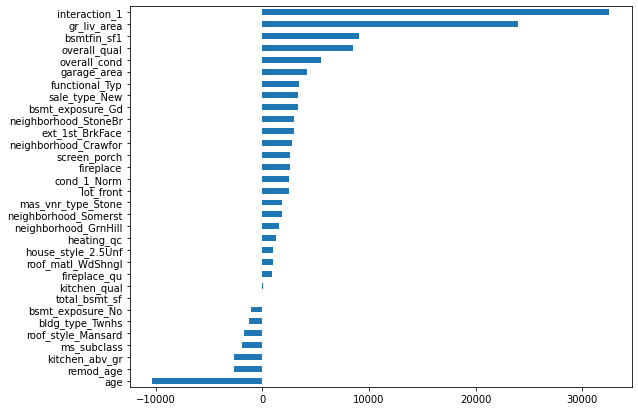

In [42]:
plt.figure(figsize=(9,7))
pd.Series(lasso_best.coef_, index = kaggle_train_final[filter_columns].columns).sort_values(ascending = True).plot.barh()

In [43]:
# Declare whole train set as X

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
lasso_best.fit(X,y)

Lasso(alpha=274.2735038773649)

In [44]:
# checking train shape 
kaggle_train_final.drop(columns = ['sale_price','id']).shape

(2047, 67)

In [45]:
# checking test shape
kaggle_test_final.drop(columns = ['sale_price','id']).shape

(878, 67)

In [46]:
# checking for any mis match in columns 

for col in kaggle_test_final.columns:
    if col not in kaggle_train_final.columns:
        print(col)

In [47]:
# Submission to kaggle 

In [48]:
# y prediction using whole Train Set
pred = lasso_best.predict(kaggle_test_final.drop(columns = ['sale_price','id']))

In [49]:
# create ID list 
id_list = list(kaggle_test_final['id'])

# create prediction list 
pred_list = list(pred)

# Create CSV 
Submission = pd.DataFrame(list(zip(id_list, pred_list)), columns = ['Id', 'SalePrice'])
Submission

,Id,SalePrice
0,2658,140113.802722
1,2718,163424.039657
2,2414,211807.629747
3,1989,105102.970028
4,625,176251.548733
...,...,...
873,1662,187941.987771
874,1234,215897.132926
875,1373,127226.721092
876,1672,118879.000168


In [50]:
Submission.to_csv('Submission.csv')

**Key Takeaways**

1) Coming out with interaction terms to cater for the synergy effect by other supposed 'independant' variables 
    which turns out highly correlated to the sale price of the house 
   
2) Having put certain classisfiers to nail down certain groups of houses to certain class does not work well, as they work as pair wise. Having the original main set works best alone.

3) 